In [ ]:
!pip install gwpy
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import sys
from tqdm import tqdm

from gwpy.timeseries import TimeSeries
import time
from gwpy.time import tconvert
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
[Errno 2] No such file or directory: 'My Drive/ML/mrp/rbm'
/content/gdrive/My Drive/ML


In [ ]:
%cd My\ Drive/ML/mrp/rbm
!pwd


[Errno 2] No such file or directory: 'My Drive/ML/mrp/rbm'
/content/gdrive/My Drive/ML
/content/gdrive/My Drive/ML


# RBM Implementation


In [ ]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import sys
from tqdm import tqdm

# Copyright (c) 2016 Michal Lukac, Egor Malykh
# Todo its an MIT license so we can use it but check whats about the changes and where to credit

class RBM:
    def __init__(self,
                 n_visible,
                 n_hidden,
                 learning_rate=0.01,
                 momentum=0.95,
                 xavier_const=1.0,
                 err_function='cosine',
                 use_tqdm=False):

        self.sample_visible = False
        self.sigma = 1
        if not 0.0 <= momentum <= 1.0:
            raise ValueError('momentum should be in range [0, 1]')

        if err_function not in {'mse', 'cosine'}:
            raise ValueError('err_function should be either \'mse\' or \'cosine\'')

        self._use_tqdm = use_tqdm
        self._tqdm = None

        if use_tqdm or tqdm is not None:
            self._tqdm = tqdm
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.sample = tf.placeholder(tf.float32, [self.n_visible])
        self.x = tf.placeholder(tf.float32, [None, self.n_visible])
        self.y = tf.placeholder(tf.float32, [None, self.n_hidden])

        self.w = tf.Variable(tf_xavier_init(n_visible, n_hidden), dtype=tf.float32)
        self.visible_bias = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)
        self.hidden_bias = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)

        self.delta_w = tf.Variable(tf.zeros([self.n_visible, self.n_hidden]), dtype=tf.float32)
        self.delta_visible_bias = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)
        self.delta_hidden_bias = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)

        self.update_weights = None
        self.update_deltas = None
        self.compute_hidden = None
        self.compute_visible = None
        self.compute_visible_from_hidden = None

        self._initialize_vars()

        assert self.update_weights is not None
        assert self.update_deltas is not None
        assert self.compute_hidden is not None
        assert self.compute_visible is not None
        assert self.compute_visible_from_hidden is not None

        # Todo change error function
        if err_function == 'cosine':
            x1_norm = tf.nn.l2_normalize(self.x, 1)
            x2_norm = tf.nn.l2_normalize(self.compute_visible, 1)
            cos_val = tf.reduce_mean(tf.reduce_sum(tf.math.multiply(x1_norm, x2_norm), 1))
            self.compute_err = tf.acos(cos_val) / tf.constant(np.pi)
        else:
            self.compute_err = tf.reduce_mean(tf.square(self.x - self.compute_visible))

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_vars(self):
        hidden_p = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
        visible_recon_p = tf.matmul(sample_bernoulli(hidden_p), tf.transpose(self.w)) + self.visible_bias

        if self.sample_visible:
            visible_recon_p = sample_gaussian(visible_recon_p, self.sigma)

        hidden_recon_p = tf.nn.sigmoid(tf.matmul(visible_recon_p, self.w) + self.hidden_bias)

        positive_grad = tf.matmul(tf.transpose(self.x), hidden_p)
        negative_grad = tf.matmul(tf.transpose(visible_recon_p), hidden_recon_p)

        def f(x_old, x_new):
            return self.momentum * x_old + \
                   self.learning_rate * x_new * (1 - self.momentum) / tf.to_float(tf.shape(x_new)[0])

        delta_w_new = f(self.delta_w, positive_grad - negative_grad)
        delta_visible_bias_new = f(self.delta_visible_bias, tf.reduce_mean(self.x - visible_recon_p, 0))
        delta_hidden_bias_new = f(self.delta_hidden_bias, tf.reduce_mean(hidden_p - hidden_recon_p, 0))

        update_delta_w = self.delta_w.assign(delta_w_new)
        update_delta_visible_bias = self.delta_visible_bias.assign(delta_visible_bias_new)
        update_delta_hidden_bias = self.delta_hidden_bias.assign(delta_hidden_bias_new)

        update_w = self.w.assign(self.w + delta_w_new)
        update_visible_bias = self.visible_bias.assign(self.visible_bias + delta_visible_bias_new)
        update_hidden_bias = self.hidden_bias.assign(self.hidden_bias + delta_hidden_bias_new)

        self.update_deltas = [update_delta_w, update_delta_visible_bias, update_delta_hidden_bias]
        self.update_weights = [update_w, update_visible_bias, update_hidden_bias]

        self.compute_hidden = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
        self.compute_visible = tf.matmul(self.compute_hidden, tf.transpose(self.w)) + self.visible_bias
        self.compute_visible_from_hidden = tf.matmul(self.y, tf.transpose(self.w)) + self.visible_bias

        self.wx_b = tf.tensordot(tf.cast(self.sample,tf.float32), self.w, axes=1) + self.hidden_bias 
        self.vbias_term = tf.tensordot(tf.cast(self.sample,tf.float32),self.visible_bias, axes=0)  
        self.hidden_term = tf.reduce_sum(tf.math.log(1 +  tf.math.exp(self.wx_b)),  reduction_indices=[0])       

    def get_err(self, batch_x):
        return self.sess.run(self.compute_err, feed_dict={self.x: batch_x})

    def get_free_energy(self, sample):             
        # vbias_term = self.sess.run(self.vbias_term, feed_dict={self.x : sample})
        return self.sess.run(-self.hidden_term - self.vbias_term, feed_dict={self.sample : sample})[0,0]
               
        # print('vbias',vbias_term.shape) 
  
        
        # tf.print( hidden_term)
       
        # return -hidden_term - vbias_term

    def transform(self, batch_x):
        return self.sess.run(self.compute_hidden, feed_dict={self.x: batch_x})

    def transform_inv(self, batch_y):
        return self.sess.run(self.compute_visible_from_hidden, feed_dict={self.y: batch_y})

    def reconstruct(self, batch_x):
        return self.sess.run(self.compute_visible, feed_dict={self.x: batch_x})

    def partial_fit(self, batch_x):
        self.sess.run(self.update_weights + self.update_deltas, feed_dict={self.x: batch_x})

    def fit(self,
            data_x,
            n_epoches=10,
            batch_size=10,
            shuffle=False,
            verbose=True):
        assert n_epoches > 0

        n_data = data_x.shape[0]

        if batch_size > 0:
            n_batches = n_data // batch_size + (0 if n_data % batch_size == 0 else 1)
        else:
            n_batches = 1

        if shuffle:
            data_x_cpy = data_x.copy()
            inds = np.arange(n_data)
        else:
            data_x_cpy = data_x

        errs = []

        for e in range(n_epoches):
            if verbose and not self._use_tqdm:
                print('Epoch: {:d}'.format(e))

            epoch_errs = np.zeros((n_batches,))
            epoch_errs_ptr = 0

            if shuffle:
                np.random.shuffle(inds)
                data_x_cpy = data_x_cpy[inds]

            r_batches = range(n_batches)

            if verbose and self._use_tqdm:
                r_batches = self._tqdm(r_batches, desc='Epoch: {:d}'.format(e), ascii=True, file=sys.stdout)

            for b in r_batches:
                batch_x = data_x_cpy[b * batch_size:(b + 1) * batch_size]
                self.partial_fit(batch_x)
                batch_err = self.get_err(batch_x)
                epoch_errs[epoch_errs_ptr] = batch_err
                epoch_errs_ptr += 1

            if verbose:
                err_mean = epoch_errs.mean()
                if self._use_tqdm:
                    self._tqdm.write('Train error: {:.4f}'.format(err_mean))
                    self._tqdm.write('')
                else:
                    print('Train error: {:.4f}'.format(err_mean))
                    print('')
                sys.stdout.flush()

            errs = np.hstack([errs, epoch_errs])

        return errs

    def get_weights(self):
        return self.sess.run(self.w), \
               self.sess.run(self.visible_bias), \
               self.sess.run(self.hidden_bias)

    def save_weights(self, filename, name):
        saver = tf.train.Saver({name + '_w': self.w,
                                name + '_v': self.visible_bias,
                                name + '_h': self.hidden_bias})
        return saver.save(self.sess, filename)

    def set_weights(self, w, visible_bias, hidden_bias):
        self.sess.run(self.w.assign(w))
        self.sess.run(self.visible_bias.assign(visible_bias))
        self.sess.run(self.hidden_bias.assign(hidden_bias))

    def load_weights(self, filename, name):
        saver = tf.train.Saver({name + '_w': self.w,
                                name + '_v': self.visible_bias,
                                name + '_h': self.hidden_bias})
        saver.restore(self.sess, filename)


def tf_xavier_init(fan_in, fan_out, const=1.0, dtype=np.float32):
    k = const * np.sqrt(6.0 / (2 + int(fan_out)))
    return tf.random_uniform(np.array([fan_in, fan_out]), minval=-k, maxval=k, dtype=dtype)


def sample_bernoulli(probs):
    return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))


def sample_gaussian(x, sigma):
    return x + tf.random_normal(tf.shape(x), mean=0.0, stddev=sigma, dtype=tf.float32)


# Prepare Data

In [ ]:
#change the top two parameters (play around with different frequencies, but higher might result in crashed due to memory usage)
sample_frequency = 1024
n_samples = 1000
start = 1187529256

def pretty(t):
  return tconvert(t).strftime("%a, %d %b %Y %H:%M:%S %Z")

def fetch(i=0, start=1126259446, delta=32):
  halfdelta=delta/2
  s,e=start+(delta*i)-halfdelta, start+(delta*(i+1))-halfdelta
  print("Fetching data for {0} to {1}".format(pretty(s), pretty(e)))
  hdata = TimeSeries.fetch_open_data('H1', s, e, cache=True)
  ldata = TimeSeries.fetch_open_data('L1', s, e, cache=True)
  # print("{0} points for H, {1} points for L".format(len(hdata), len(ldata)))
  return (hdata, ldata)

def filter_gwe(data:TimeSeries):
  from gwpy.signal import filter_design
  bp = filter_design.bandpass(50, 250, data.sample_rate)
  notches = [filter_design.notch(line, data.sample_rate) for line in (60, 120, 180)]
  zpk = filter_design.concatenate_zpks(bp, *notches)
  filt = data.filter(zpk, filtfilt=True)
  data = data.crop(*data.span.contract(1))
  filt = filt.crop(*filt.span.contract(1))
  resample = filt.resample(sample_frequency)
  return resample

def scale(data):
  avg = np.average(data)
  sigma = np.std(data)
  return (data - avg) / sigma

print("Sampling", n_samples, "datapoints at",sample_frequency,"Hz")
data_h, data_l = fetch(start=start, delta=8)
test_sample = filter_gwe(data_h)
data_points = len(test_sample)
x_train = np.zeros((n_samples,data_points*2))
for i in range(1,n_samples):
  e = start + (8 * i)
  data_h, data_l = fetch(start=e, delta=8)
  filt_h = np.asarray(filter_gwe(data_h))
  filt_h = scale(filt_h)
  filt_l = np.asarray(filter_gwe(data_l))
  filt_l = scale(filt_l)
  x_train[i,0:len(filt_h)] = filt_h
  x_train[i,len(filt_h):] = filt_l
  print(i)
np.save('x_train_rbm.npy',x_train)
x_train = np.load('x_train_rbm.npy')
#   # plt.subplot(3,1,1)
#   # plt.plot(data)
#   # plt.subplot(3,1,2)
#   plt.plot(filt)
#   # plt.subplot(3,1,3)
#   # (data.spectrogram(3, fftlength=3, overlap=2) ** (1/2.)).plot()
#   plt.show()

In [ ]:
print("Sampling", n_samples, "datapoints at",sample_frequency,"Hz")
data_h, data_l = fetch(start=start, delta=8)
test_sample = filter_gwe(data_h)
data_points = len(test_sample)

recorded_events=[1126259462, 1128678900, 1135136350, 1167559936, 1180922494, 1185389807, 1186302519, 1186741861, 1187008882, 1187058327, 1187529256]
events = np.zeros((len(recorded_events), data_points*2))
for i in range(len(recorded_events)):
  data_h, data_l = fetch(start=recorded_events[i], delta=8)
  filt_h = np.asarray(filter_gwe(data_h))
  filt_h = scale(filt_h)
  filt_l = np.asarray(filter_gwe(data_l))
  filt_l = scale(filt_l)
  events[i,0:len(filt_h)] = filt_h
  events[i,len(filt_h):] = filt_l

np.save('events.npy',events)

Sampling 300 datapoints at 1024 Hz
Fetching data for Wed, 23 Aug 2017 13:13:54  to Wed, 23 Aug 2017 13:14:02 
Fetching data for Mon, 14 Sep 2015 09:50:41  to Mon, 14 Sep 2015 09:50:49 
Fetching data for Mon, 12 Oct 2015 09:54:39  to Mon, 12 Oct 2015 09:54:47 
Fetching data for Sat, 26 Dec 2015 03:38:49  to Sat, 26 Dec 2015 03:38:57 
Fetching data for Wed, 04 Jan 2017 10:11:54  to Wed, 04 Jan 2017 10:12:02 
Fetching data for Thu, 08 Jun 2017 02:01:12  to Thu, 08 Jun 2017 02:01:20 
Fetching data for Sat, 29 Jul 2017 18:56:25  to Sat, 29 Jul 2017 18:56:33 
Fetching data for Wed, 09 Aug 2017 08:28:17  to Wed, 09 Aug 2017 08:28:25 
Fetching data for Mon, 14 Aug 2017 10:30:39  to Mon, 14 Aug 2017 10:30:47 
Fetching data for Thu, 17 Aug 2017 12:41:00  to Thu, 17 Aug 2017 12:41:08 
Fetching data for Fri, 18 Aug 2017 02:25:05  to Fri, 18 Aug 2017 02:25:13 
Fetching data for Wed, 23 Aug 2017 13:13:54  to Wed, 23 Aug 2017 13:14:02 


# Train RBM

In [ ]:
#first parameter is the number of visible units (restriced by data format) & the number of hidden units is the second parameter
rbm = RBM((data_points*2), (data_points*3), learning_rate=0.01, momentum=0.95, xavier_const=1.0, use_tqdm=True)
rbm.fit(x_train, n_epoches=10, batch_size=20)
# # Check saving works befor training for a long time!!!
rbm.save_weights(filename='rbm-weights', name='rbm-weights')

In [ ]:
rbm = RBM((data_points*2), (data_points*3), learning_rate=0.01, momentum=0.95, xavier_const=1.0, use_tqdm=True)
rbm.load_weights(filename='rbm-weights', name='rbm-weights')
result = rbm.get_free_energy(x_train[1])
print(result)

INFO:tensorflow:Restoring parameters from rbm-weights
-15537.223


[-12776.06445312 -15537.22265625 -15568.49609375 ...
 -15587.01171875 -15566.0078125  -15608.81835938]


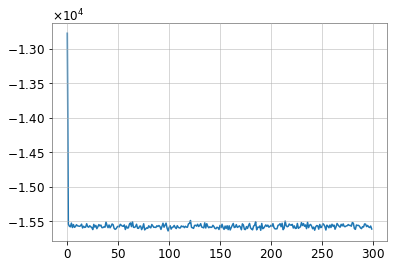

In [ ]:
test_samples = np.zeros((x_train.shape[0]))
for i in range(x_train.shape[0]):
  test_samples[i] = rbm.get_free_energy(x_train[i])

print(test_samples)
plt.plot(test_samples)

-15572.7587890625
-15562.000706380208
0.5:  -15623.410527343749 99.5:  -15503.487500000001


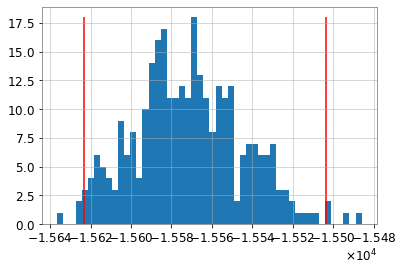

In [ ]:
med = np.median(test_samples)
print(med)
avg = np.average(test_samples)
print(avg)

fig, ax = plt.subplots()
ax.hist(test_samples[1:], bins=50)
upper_bound = np.percentile(test_samples[1:], 99)
lower_bound = np.percentile(test_samples[1:], 1)

print("0.5: ", lower_bound,"99.5: ", upper_bound)
ax.vlines(upper_bound, 0, 18, colors='r')
ax.vlines(lower_bound, 0, 18, colors='r')
fig.savefig('Dist.png', dpi=300)

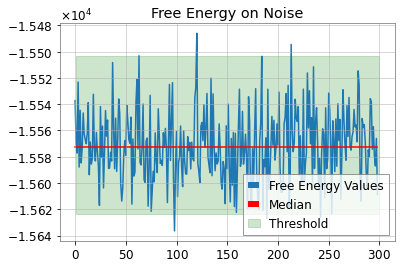

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Free Energy on Noise')
ax.plot(test_samples[1:], label='Free Energy Values')
med_line = np.array([med for i in range(len(test_samples[1:]))])
upper_line = np.array([upper_bound for i in range(len(test_samples[1:]))])
lower_line = np.array([lower_bound for i in range(len(test_samples[1:]))])
ax.plot(med_line, color='r', label='Median')
ax.fill_between(np.linspace(1,300,299),lower_line, upper_line, alpha=0.2,color='g', label='Threshold')
# ax.plot(upper_line, color='r')
# ax.plot(lower_line, color='r')
ax.legend(loc='lower right')
fig.savefig('Corridor.png', dpi=300)

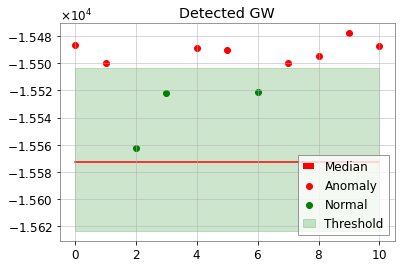

In [ ]:
event_energies = np.zeros(events.shape[0])
for i in range(len(events)):
  event_energies[i] = rbm.get_free_energy(events[i])

# print(event_energies)
# plt.plot(event_energies)

annomalies = np.copy(event_energies)
normal = np.copy(event_energies)
for i in range(len(event_energies)):
  if lower_bound < event_energies[i] < upper_bound:
    annomalies[i] = np.NaN
  else:
    normal[i] = np.NaN

fig, ax = plt.subplots()
ax.set_title('Detected GW')

ax.scatter(np.linspace(0,10,11),annomalies, c='r', label='Anomaly')
ax.scatter(np.linspace(0,10,11),normal , c='g', label='Normal')
med_line = np.array([med for i in range(len(event_energies))])
upper_line = np.array([upper_bound for i in range(len(event_energies))])
lower_line = np.array([lower_bound for i in range(len(event_energies))])
ax.plot(med_line, color='r', label='Median')
ax.fill_between(np.linspace(0,10,11),lower_line, upper_line, alpha=0.2,color='g',label='Threshold')
ax.legend(loc='lower right')
fig.savefig('Annomalies.png', dpi=300)
